**30E03000 - Data Science for Business I (2019)**

# Assignment 2: Credit Risk Modeling

## Import libraries

In [31]:
import pandas as pd 
import numpy as np
import itertools

#using matplotlib for graphs 
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks

#importing sklearn for modelling 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #Decision Tree algorithm
from sklearn.model_selection import train_test_split #Data split function
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE


#Decision tree plot
import pydotplus
from IPython.display import Image 

## Import data

In [32]:
#import the data into a Pandas dataframe and show it
data =pd.read_csv("credit.csv")
data.head(10).style

,OBS#,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIOTV,EDUCATION,RETRAINING,AMOUNT,SAV_ACCT,EMPLOYMENT,INSTALL_RATE,MALE_DIV,MALE_SINGLE,MALE_MAR_or_WID,COAPPLICANT,GUARANTOR,PRESENT_RESIDENT,REAL_ESTATE,PROP_UNKN_NONE,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
0,1,0,6,4,0,0,0,1,0,0,1169,4,4,4,0,1,0,0,0,4,1,0,67,0,0,1,2,2,1,1,0,1
1,2,1,48,2,0,0,0,1,0,0,5951,0,2,2,0,0,0,0,0,2,1,0,22,0,0,1,1,2,1,0,0,0
2,3,3,12,4,0,0,0,0,1,0,2096,0,3,2,0,1,0,0,0,3,1,0,49,0,0,1,1,1,2,0,0,1
3,4,0,42,2,0,0,1,0,0,0,7882,0,3,2,0,1,0,0,1,4,0,0,45,0,0,0,1,2,2,0,0,1
4,5,0,24,3,1,0,0,0,0,0,4870,0,2,3,0,1,0,0,0,4,0,1,53,0,0,0,2,2,2,0,0,0
5,6,3,36,2,0,0,0,0,1,0,9055,4,2,2,0,1,0,0,0,4,0,1,35,0,0,0,1,1,2,1,0,1
6,7,3,24,2,0,0,1,0,0,0,2835,2,4,3,0,1,0,0,0,4,0,0,53,0,0,1,1,2,1,0,0,1
7,8,1,36,2,0,1,0,0,0,0,6948,0,2,2,0,1,0,0,0,2,0,0,35,0,1,0,1,3,1,1,0,1
8,9,3,12,2,0,0,0,1,0,0,3059,3,3,2,1,0,0,0,0,4,1,0,61,0,0,1,1,1,1,0,0,1
9,10,1,30,4,1,0,0,0,0,0,5234,0,0,4,0,0,1,0,0,2,0,0,28,0,0,1,2,3,1,0,0,0


## Data exploration

In [33]:
# Exploring the data
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
OBS#                1000 non-null int64
CHK_ACCT            1000 non-null int64
DURATION            1000 non-null int64
HISTORY             1000 non-null int64
NEW_CAR             1000 non-null int64
USED_CAR            1000 non-null int64
FURNITURE           1000 non-null int64
RADIOTV             1000 non-null int64
EDUCATION           1000 non-null int64
RETRAINING          1000 non-null int64
AMOUNT              1000 non-null int64
SAV_ACCT            1000 non-null int64
EMPLOYMENT          1000 non-null int64
INSTALL_RATE        1000 non-null int64
MALE_DIV            1000 non-null int64
MALE_SINGLE         1000 non-null int64
MALE_MAR_or_WID     1000 non-null int64
COAPPLICANT         1000 non-null int64
GUARANTOR           1000 non-null int64
PRESENT_RESIDENT    1000 non-null int64
REAL_ESTATE         1000 non-null int64
PROP_UNKN_NONE      1000 non-null int64
AGE           

**Summary**

After data exploration we found that 
* Their are no missing entries ( each column has 1000 values) 
* No NaN values
* All the values are intergers

## Data visualization

[700 300]


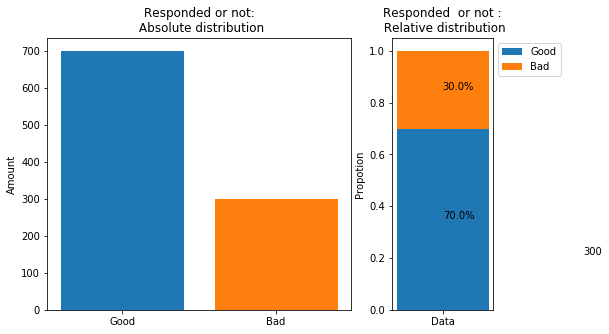

In [35]:
#Visualize 
one,zero = list(data["RESPONSE"]).count(1),list(data["RESPONSE"]).count(0) # amount of 1 and 0
lista = np.array([one,zero])
prop=lista/lista.sum()

print(lista)

fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1])

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['Good', 'Bad'], lista, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Responded or not:\n Absolute distribution') 
ax0 = plt.ylabel('Amount')
ax0 = plt.text(['Response'], lista[0]/2, lista[0]) 
ax0 = plt.text(['No response'], lista[1]/2, lista[1])

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [prop[0]], label='Good')
ax1 = plt.bar(['Data'], [prop[1]], bottom=prop[0], label='Bad')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Responded  or not :\n Relative distribution')
ax1 = plt.ylabel('Propotion')
ax1 = plt.text(['Data'],prop[0]/2, '{}%'.format((prop[0]*100).round(1)))
ax1 = plt.text(['Data'],(prop[1]/2)+prop[0], '{}%'.format((prop[1]*100).round(1)))


#plt.hist(zero)
plt.show()

## Data preprocessing

In [36]:
#Dropping OBS# (observation nr) as it is essentially just row nr and has no explanatory power
data = data.drop(['OBS#'], axis=1) #axis=1 drops a column (axis=0 drops a row)
data.head()

,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIOTV,EDUCATION,RETRAINING,AMOUNT,...,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
0,0,6,4,0,0,0,1,0,0,1169,...,67,0,0,1,2,2,1,1,0,1
1,1,48,2,0,0,0,1,0,0,5951,...,22,0,0,1,1,2,1,0,0,0
2,3,12,4,0,0,0,0,1,0,2096,...,49,0,0,1,1,1,2,0,0,1
3,0,42,2,0,0,1,0,0,0,7882,...,45,0,0,0,1,2,2,0,0,1
4,0,24,3,1,0,0,0,0,0,4870,...,53,0,0,0,2,2,2,0,0,0


## Data split

In [37]:
X, y = data.loc[:, data.columns != 'RESPONSE'], data['RESPONSE'] #define feature matrix X and labels y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234) #split data 70:30

## Checking if Split was successful 

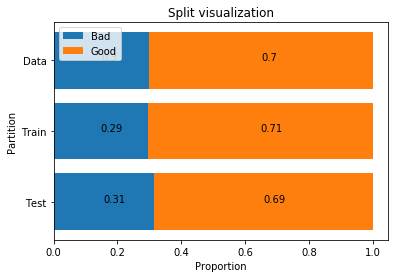

In [38]:
train_dist = y_train.value_counts() / len(y_train) #normalizing y_train
test_dist = y_test.value_counts() / len(y_test)  #normalizing y_test
data_dist = data['RESPONSE'].value_counts() / len(data) 

fig, ax = plt.subplots()
ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='Bad')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='Good')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

The Split was successful 

## Build an (unbalanced) Decision Tree model

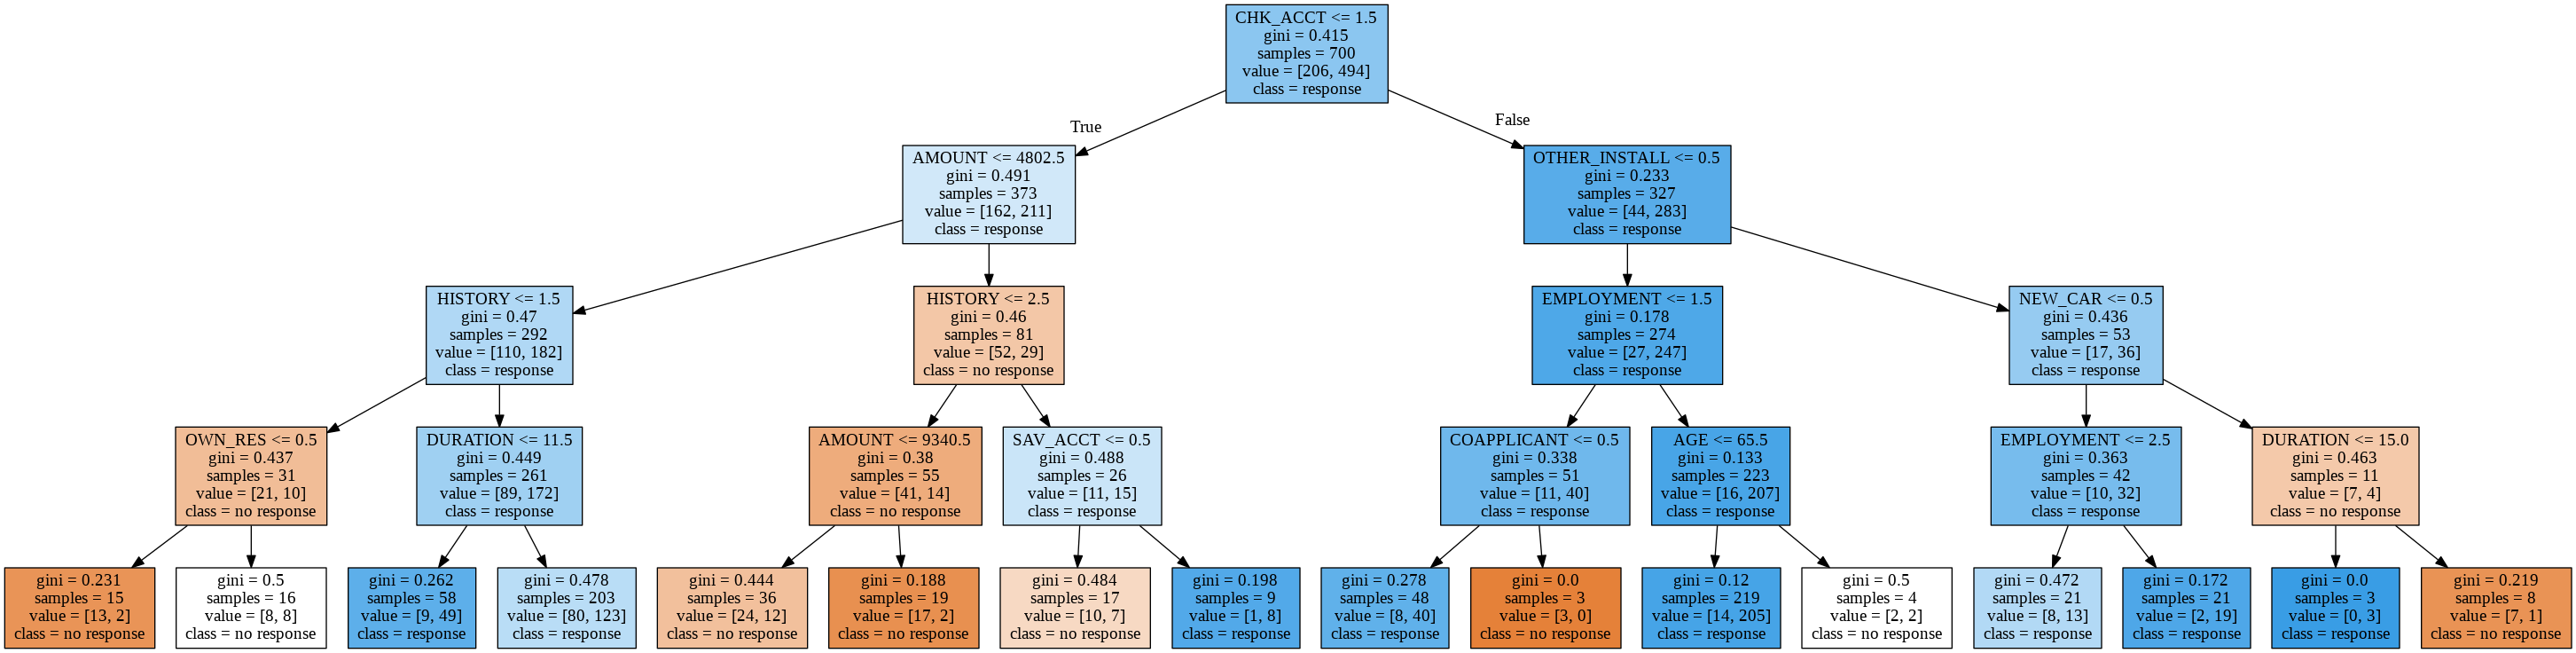

In [86]:
#Define Decision tree classifier with some default parameters
clf = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=4, min_samples_leaf=3)

#Fit the training data 
clf.fit(X_train, y_train)

#Use classifier to predict labels
y_pred = clf.predict(X_test)

'''
The graphviz library is used to visualize the tree. 
'''

# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['no response', 'response'], filled=True) #or use y_train.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# Create PNG 
#graph.write_png("clf.png") #uncomment this line to save the plot as a .png file

In [87]:
#Accuracy for Unbalanced Tree 
print ("Accuracy is: ", (accuracy_score(y_test,y_pred)*100).round(2))

Accuracy is:  69.67


## Rebalancing with SMOTE

In [88]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train) #ONLY APPLIED TO TRAINING!!!

## Build a balanced Decision Tree model

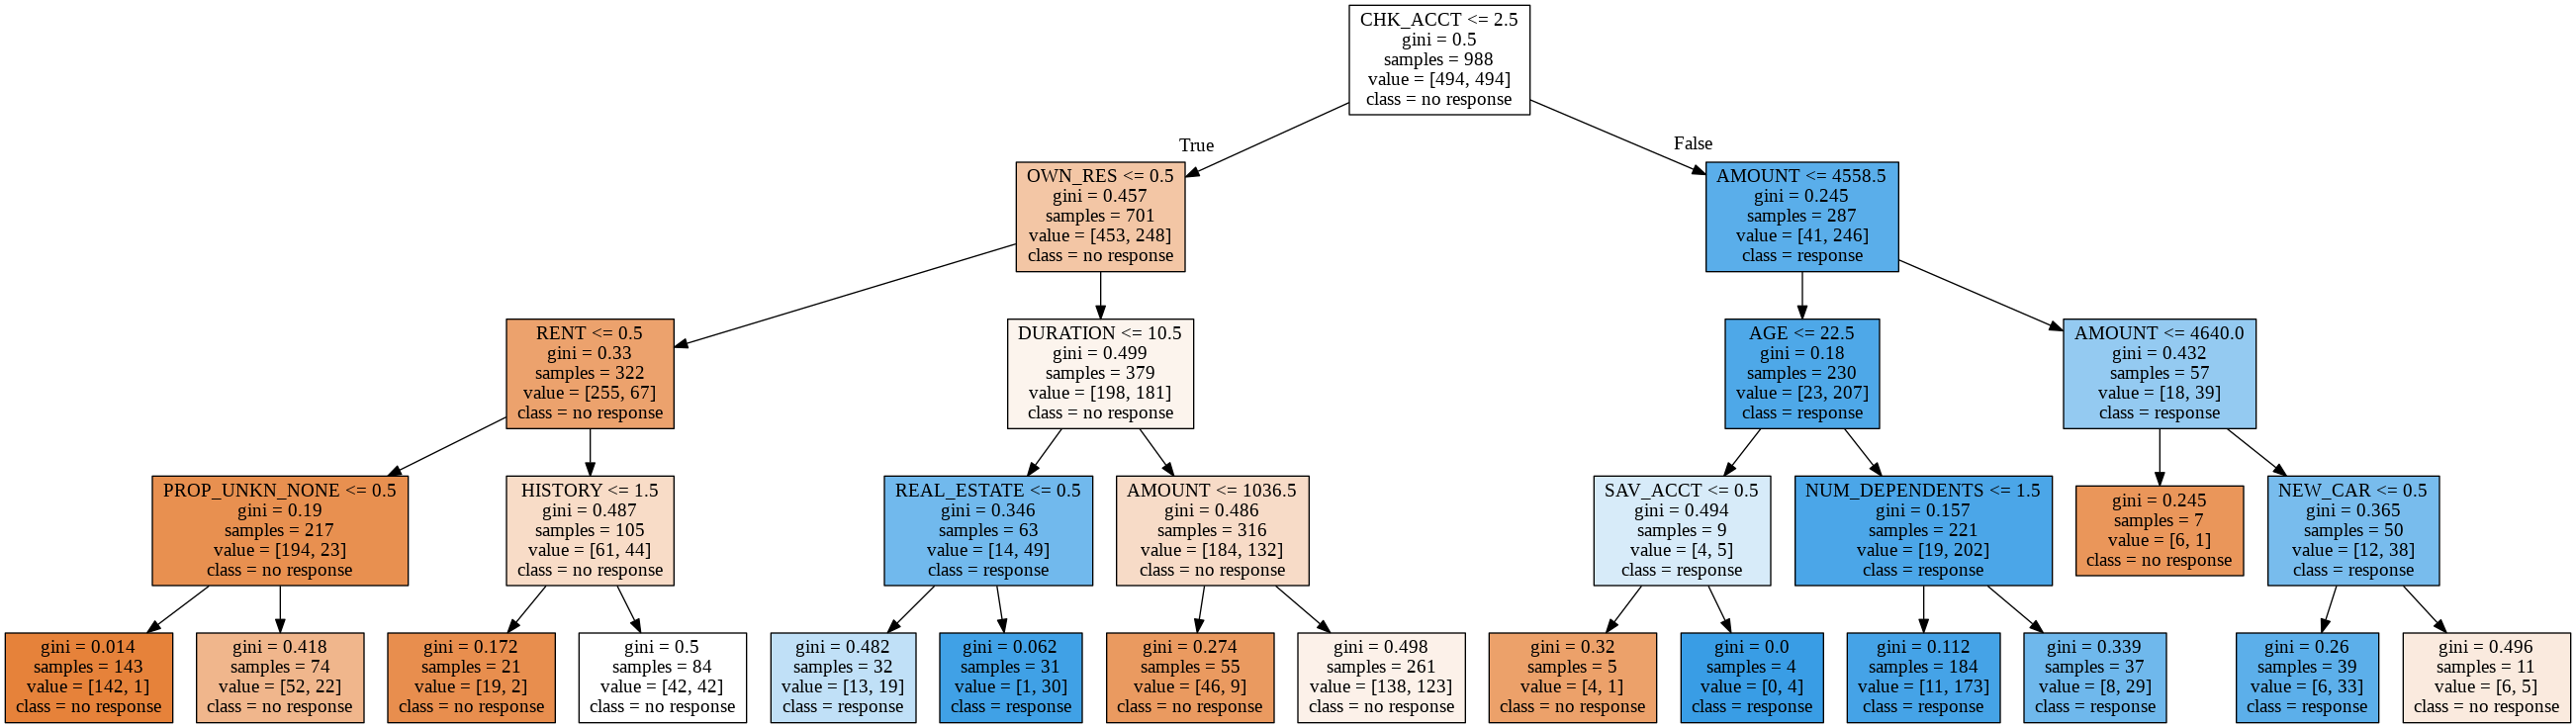

In [89]:
#Define Decision tree classifier with some default parameters
clf_sm = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=4, min_samples_leaf=4)

#Fit the training data 
clf_sm.fit(X_sm, y_sm)

#Using Classifier to predict labels
y_pred_sm = clf_sm.predict(X_test)


'''
The graphviz library is used to visualize the tree. 
'''

# Create DOT data
dot_data = tree.export_graphviz(clf_sm, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['no response', 'response'], filled=True) #or use y_sm.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# Create PNG 
#graph.write_png("clf_sm.png") #uncomment this line to save the plot as a .png file

In [90]:
#Accuracy for Balanced Tree 
print ("Accuracy is: ", (accuracy_score(y_test,y_pred_sm)*100).round(2))

Accuracy is:  62.33


## Feature Importance

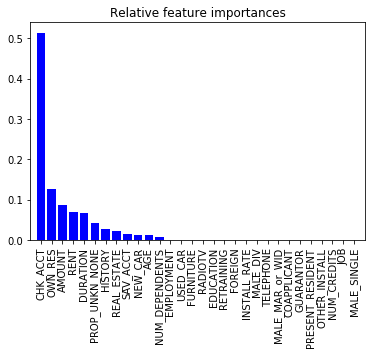

In [91]:
importances = clf_sm.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Model evaluation

### 1. Confusion Matrix ( For Unbalanced Data ) 


In [92]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

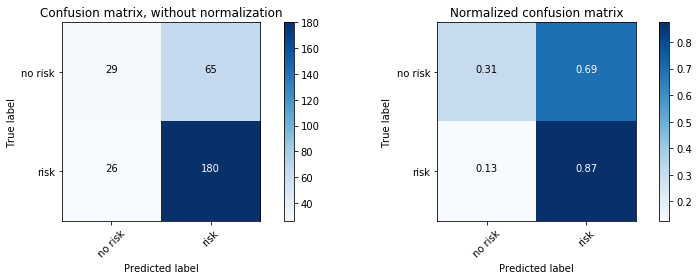

In [93]:
# Compute confusion matrix
class_names = ['no risk', 'risk']
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 4))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 2. Confusion Matrix ( For Balanced Data ) 


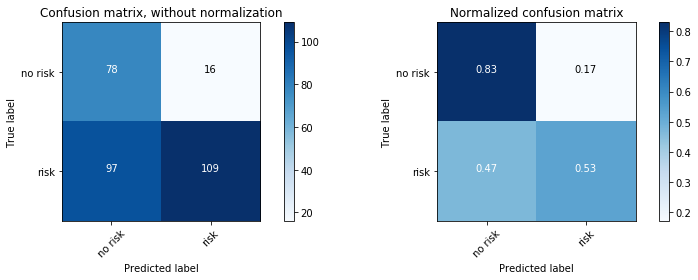

In [95]:
# Compute confusion matrix
class_names = ['no risk', 'risk']
cnf_matrix = confusion_matrix(y_test, y_pred_sm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 4))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### AUC ( For Unbalanced Data)


In [96]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("AUC score on Testing: " + str(roc_auc))

AUC score on Testing: 0.591148523032


### Plotting  ROC ( For Unbalanced Data)


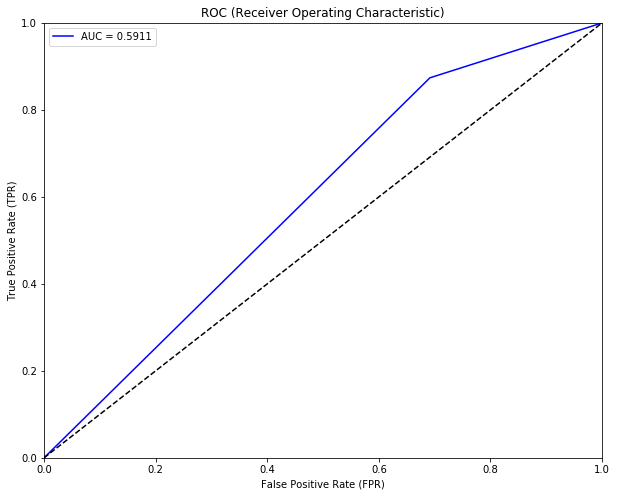

In [97]:
fig, axs = plt.subplots(1,1, figsize=(10,8))

plt.title('ROC (Receiver Operating Characteristic)')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f'% roc_auc)
plt.legend(loc='best')
plt.plot([0,1],[0,1],color='black', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)');

### AUC ( For Balanced Data)

In [98]:
fpru, tpru, thresholdsu = roc_curve(y_test, y_pred_sm)
roc_auc_u = auc(fpru, tpru)
print("AUC score on Testing: " + str(roc_auc_u))

AUC score on Testing: 0.679456723817


### Plotting ROC (Balanced Data)

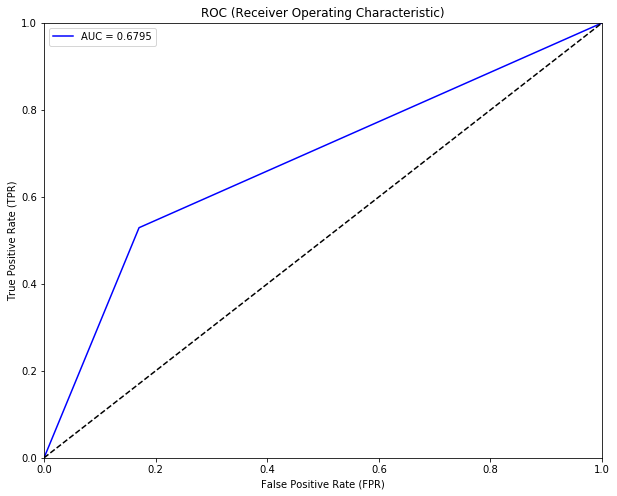

In [99]:
fig, axs = plt.subplots(1,1, figsize=(10,8))

plt.title('ROC (Receiver Operating Characteristic)')
plt.plot(fpru, tpru, 'b', label='AUC = %0.4f'% roc_auc_u)
plt.legend(loc='best')
plt.plot([0,1],[0,1],color='black', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)');

### Conclusion 

The unbalanced model gave us an accuracy of 69.67% and the balanced model(balanced using SMOTE) gave us an accuracy of 62.67% . However, this is misleading. By looking at the confusion matrix we conclude that in the case of the unbalanced data, the model classifies only 31% cases correctly as no risk and 87%  correctly as risk. The balanced data model shows that 83 % were correctly classified as no-risk and 53 % were correctly classified as risk. We think that unbalanced model is biased towards the "risk" category and is putting majority predictions under that category. Also, we also looked at the shape of the ROC plot and the Area Under the Curve(AOC) which is more for the balanced data model and cocluded the that the model with balanced data is a better choice for deployment.